In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
#This creates the SQL Lite engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#Check to make sure tables look correct - station, date, precip,tobs
engine.execute('SELECT * FROM measurement limit 20').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0)]

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

#Create Trip Dates
trip_start = '2017-02-01'
trip_end = '2017 - 02 -10'

# Climate Analysis

In [7]:
#Design a query to retrieve the last 12 months of precipitation data.
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print('Last Date In Database', last_date,'Year Ago:', year_ago)

#Design a query to retrieve the last 12 months of precipitation data.
session.query(Measurement.prcp).filter(func.strftime("%"))

L365_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()

#L365_precip

Last Date In Database ('2017-08-23',) Year Ago: 2016-08-23


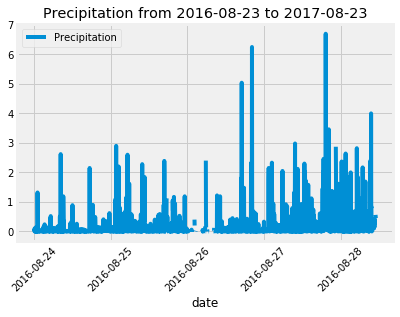

In [8]:
# Sort the dataframe by date
precip_df = pd.DataFrame(L365_precip, columns=['date', 'prcp'])
precip_df.set_index('date', inplace = True)
precip_df = precip_df.rename(columns = {'prcp':'Precipitation','date': 'Date'})

# #Plot the results using the DataFrame plot method.
precip_plot = precip_df.plot()
precip_plot.set_xticklabels(precip_df.index,rotation=45)
precip_plot.set_title("Precipitation from 2016-08-23 to 2017-08-23")
precip_plot
plt.savefig("../SQL-ALCHEMY---Advanced-Data-Storage-and-Retrieval/L365Precip.png")


![precipitation](Images/precipitation.png)

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [10]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).all()
print(f'There are {len(total_stations)} total stations.')

print(len(total_stations))

There are 9 total stations.
9


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Station.name, Station.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.name, Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_df= pd.DataFrame(most_active_stations, columns=['Station', 'Station ID', 'Total Temperature Observations' ])

print('*Waihee is the most active station with 2,772 temperature observations*')
station_df

*Waihee is the most active station with 2,772 temperature observations*


,Station,Station ID,Total Temperature Observations
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
highest_temp = session.query(Measurement.tobs).order_by(Measurement.tobs.desc()).first()
lowest_temp = session.query(Measurement.tobs).order_by(Measurement.tobs.asc()).first()
average_temp = session.query(func.avg(Measurement.tobs)).order_by(Measurement.tobs).first()

print(f"Highest Temp: {highest_temp} Lowest Temp: {lowest_temp} Avg Temp,{average_temp}")

Highest Temp: (87.0,) Lowest Temp: (53.0,) Avg Temp,(73.09795396419437,)


In [13]:
# Choose the station with the highest number of temperature observations. 
#Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Last 12 Months of TOBS Data
session.query(Measurement.tobs).filter(func.strftime("%"))

L365_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).all()

#Find L12 Most Active Station
L365_most_active_station = session.query(Station.name, Station.station, func.count(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Measurement.date >= year_ago).\
    group_by(Station.name, Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

L365_most_active_station

[('WAIKIKI 717.2, HI US', 'USC00519397', 361),
 ('WAIHEE 837.5, HI US', 'USC00519281', 352),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 349),
 ('KANEOHE 838.1, HI US', 'USC00513117', 343),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 337),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 305),
 ('PEARL CITY, HI US', 'USC00517948', 183)]

In [24]:
#Last 12 months of Tobs data for Waikiki
#First try didn't work - this worked when you added back in Measurement.station so that you could filter on the tobs in the histogram
L365_tobs = session.query(Measurement.station, Measurement.station, Measurement.tobs).filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519397').all()

tobs_df = pd.DataFrame(L365_tobs)
tobs_df.head()

,station,station,tobs
0,USC00519397,USC00519397,81.0
1,USC00519397,USC00519397,79.0
2,USC00519397,USC00519397,80.0
3,USC00519397,USC00519397,79.0
4,USC00519397,USC00519397,77.0


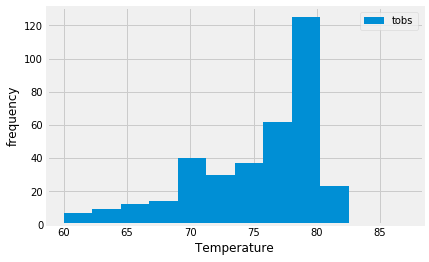

In [28]:
# #Plot the results using the DataFrame plot method.
plt.hist(tobs_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("frequency")
plt.legend(["tobs"])
plt.show()